In this notebook, I perform customer segmentation for a (fake) businessperson with an ownership stake in 10 malls across Istanbul.

**DATA**

I obtained data
- from [this Kaggle posting](https://www.kaggle.com/datasets/mehmettahiraslan/customer-shopping-dataset)
- on 99,457 transactions
- occurring at 10 malls in Istanbul
- between the beginning of 2021 and late 2023.

**METHODS**
- K means clustering is the method applied to group customers.
- Principal component analysis is also used to visualize the clusters and improve the performance of the clustering algorithm.

#### Imports

In [2]:
from zipfile import ZipFile

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

#### Load Data

In [14]:
with ZipFile('Data/customer_shopping.zip') as zipArchive:
    with zipArchive.open('customer_shopping_data.csv') as f:
        raw = pd.read_csv(f)
raw.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


#### Data Manipulation and Exploration

In [8]:
raw.shape

(99457, 10)

In [9]:
raw.shopping_mall.value_counts(normalize=True)

Mall of Istanbul     0.200519
Kanyon               0.199312
Metrocity            0.150930
Metropol AVM         0.102165
Istinye Park         0.098344
Zorlu Center         0.051027
Cevahir AVM          0.050182
Forum Istanbul       0.049740
Viaport Outlet       0.049408
Emaar Square Mall    0.048373
Name: shopping_mall, dtype: float64

In [180]:
data = raw.copy()

In [181]:
data['invoice_date'] = pd.to_datetime(raw.invoice_date)

In [182]:
data.invoice_date.min()

Timestamp('2021-01-01 00:00:00')

In [183]:
data.invoice_date.max()

Timestamp('2023-12-02 00:00:00')

Data begins at the beginning of the year in 2021 and continues until the end of December 1st in 2023 (almost 2 years of data.)

In [22]:
data.customer_id.value_counts()

C212434    1
C242489    1
C169646    1
C201572    1
C276012    1
          ..
C962346    1
C298363    1
C907544    1
C124476    1
C552345    1
Name: customer_id, Length: 99457, dtype: int64

Each customer is only represented once in the dataset, so I'm not sure that we have enough information to perform a customer segmentation as I envisioned it (based on shopping habits over time.)

Instead, we'll have to segment customers by the single purchase recorded in our dataset and demographic information like age and gender.

In [23]:
data.category.value_counts(normalize=True)

Clothing           0.346753
Cosmetics          0.151794
Food & Beverage    0.148567
Toys               0.101421
Shoes              0.100888
Souvenir           0.050263
Technology         0.050233
Books              0.050082
Name: category, dtype: float64

In [24]:
data.gender.value_counts(normalize=True)

Female    0.598068
Male      0.401932
Name: gender, dtype: float64

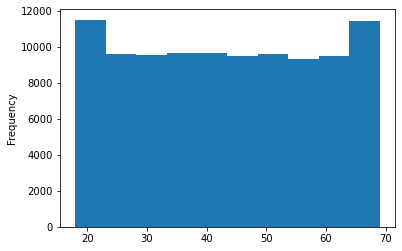

In [26]:
data.age.plot(kind='hist');

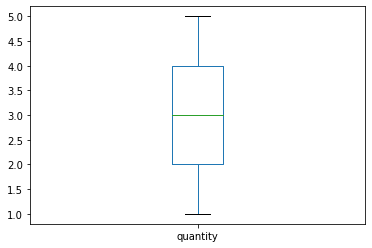

In [29]:
data.quantity.plot(kind='box');

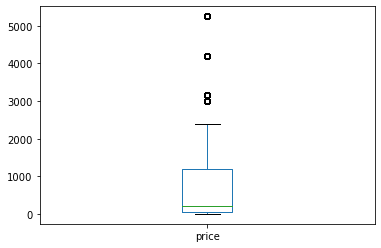

In [30]:
data.price.plot(kind='box');

In [184]:
data['avg_price_per_item'] = data['price'] / data['quantity']

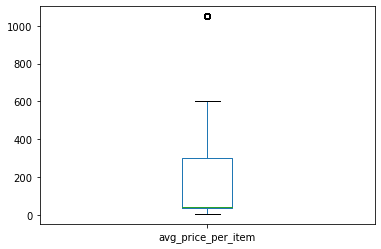

In [185]:
data['avg_price_per_item'].plot(kind='box');

In [33]:
data.payment_method.value_counts(normalize=True)

Cash           0.446897
Credit Card    0.351217
Debit Card     0.201886
Name: payment_method, dtype: float64

In [186]:
data.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,avg_price_per_item
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,2022-05-08,Kanyon,300.08
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul,600.17
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,2021-09-11,Metrocity,300.08
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,2021-05-16,Metropol AVM,600.17
4,I337046,C189076,Female,53,Books,4,60.60,Cash,2021-10-24,Kanyon,15.15


For the customer segmentation, let's ignore shopping mall because we want to capture patterns in customer consuption, not necessarily their geographic location. Because our customers are each only represented once in our dataset, I'm not sure how much information about the customer we will get from the last time that they bought an item at one of these malls, so let's ignore invoice_date as well.

In [192]:
data.drop(['customer_id', 'invoice_no', 'invoice_date', 'shopping_mall'], axis=1, inplace=True)
data.head(2)

,gender,age,category,quantity,price,payment_method,avg_price_per_item
0,Female,28,Clothing,5,1500.40,Credit Card,300.08
1,Male,21,Shoes,3,1800.51,Debit Card,600.17


In [187]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore')

transformed = pd.concat([
    pd.DataFrame(ohe.fit_transform(data[['gender', 'category', 'payment_method']]).todense(),
                 columns=np.concatenate(ohe.categories_, axis=0)),
    data[['quantity', 'price']]
],
    axis=1)

In [188]:
transformed.head(2)

,Female,Male,Books,Clothing,Cosmetics,Food & Beverage,Shoes,Souvenir,Technology,Toys,Cash,Credit Card,Debit Card,quantity,price
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5,1500.40
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3,1800.51


In [189]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

transformed = pd.DataFrame(ss.fit_transform(transformed),
                           index=transformed.index,
                           columns=transformed.columns)

In [190]:
transformed.head(2)

,Female,Male,Books,Clothing,Cosmetics,Food & Beverage,Shoes,Souvenir,Technology,Toys,Cash,Credit Card,Debit Card,quantity,price
0,0.819788,-0.819788,-0.229614,1.372552,-0.423036,-0.41772,-0.334975,-0.23005,-0.229977,-0.335958,-0.898877,1.359133,-0.502946,1.412984,0.861837
1,-1.219828,1.219828,-0.229614,-0.728570,-0.423036,-0.41772,2.985297,-0.23005,-0.229977,-0.335958,-0.898877,-0.735763,1.988287,-0.002426,1.180703


#### Clustering

In [129]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score as ch_score

scores = []
for k in range(2,10):
    k_means = KMeans(n_clusters=k, random_state=34)
    k_means.fit(transformed)
    scores.append(ch_score(transformed, k_means.labels_))

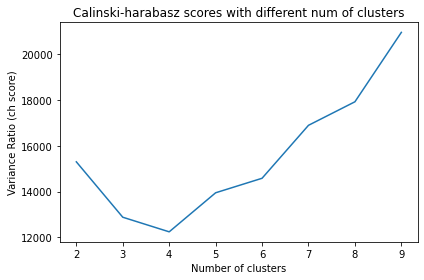

In [130]:
fig, ax = plt.subplots()

plt.plot(range(2, 10), scores)
ax.set(title='Calinski-harabasz scores with different num of clusters',
       xlabel='Number of clusters',
       ylabel='Variance Ratio (ch score)')

fig.tight_layout();

It appears that the variance ratio reaches its minimum at 4 neighbors.

After that point, as the number of clusters increases, the ratio of the intra-cluster variance to inter-cluster variance increases steadily. This intuitively makes sense; if there are naturally 4 clusters in the data, then if we split it into 5 clusters, we are splitting a cluster in half which will lower the inter-cluster variance (because we are treating two points which should be in the same cluster as if they are in different clusters.)

Let's also record the silhouette score for this model.

In [160]:
from sklearn.metrics import silhouette_score

k_means = KMeans(n_clusters=4)
k_means.fit(transformed)

silhouette_score(transformed, k_means.labels_)

0.19934093259952448

Check the results of increasing the number of clusters beyond 10.

In [131]:
scores = []
for k in range(2,50):
    k_means = KMeans(n_clusters=k, random_state=34)
    k_means.fit(transformed)
    scores.append(ch_score(transformed, k_means.labels_))

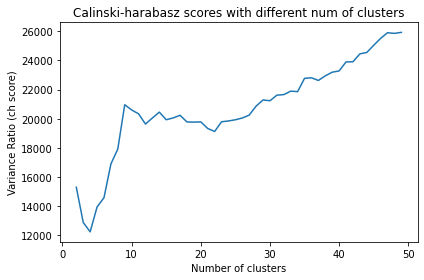

In [132]:
fig, ax = plt.subplots()

plt.plot(range(2, 50), scores)
ax.set(title='Calinski-harabasz scores with different num of clusters',
       xlabel='Number of clusters',
       ylabel='Variance Ratio (ch score)')

fig.tight_layout();

To visualize the clusters, and possibly enhance the performance of k-means clustering, I am going to experiment with using principal components analysis.

For ease of plotting, we can start with two principal components.

In [124]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=34)

transformed_in_2d = pca.fit_transform(transformed)

In [125]:
transformed_in_2d.shape

(99457, 2)

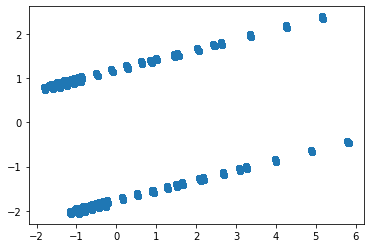

In [126]:
fig, ax = plt.subplots()

plt.scatter(transformed_in_2d[:, 0], transformed_in_2d[:, 1]);

Using principal components analysis with two principal components retained, we see a clear pattern in the data. It looks like there should only be two groups. How much of the variance in the data is captured by the first two principal components?

In [127]:
pca.explained_variance_ratio_

array([0.13412572, 0.13331976])

The first component explains ~13.4% of the variance in the data, and the second component also explains about 13% of the variance.

Let's see how much more variance is explained by a third principal component.

In [135]:
pca = PCA(n_components=3, random_state=34)

transformed_in_3d = pca.fit_transform(transformed)

print(pca.explained_variance_ratio_)

[0.13412572 0.13331976 0.11129851]


We're now explaining a cumulative total of about 38% of the variance in our data.

Here is the data in three dimensions visualized using color for the third dimension:

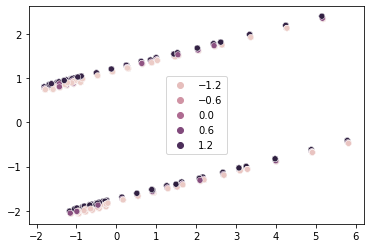

In [139]:
import seaborn as sns

fig, ax = plt.subplots()

sns.scatterplot(x=transformed_in_3d[:, 0], y=transformed_in_3d[:, 1], hue=transformed_in_3d[:, 2]);

And here is the data in three dimensions visualized spatially:

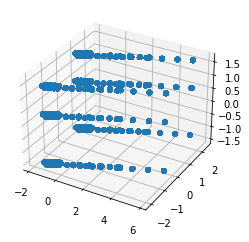

In [141]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(transformed_in_3d[:, 0], transformed_in_3d[:, 1], transformed_in_3d[:, 2]);

In [143]:
pca = PCA(n_components=4, random_state=34)

transformed_in_4d = pca.fit_transform(transformed)

print(pca.explained_variance_ratio_)

[0.13412572 0.13331976 0.11129851 0.09147993]


In [144]:
np.sum(pca.explained_variance_ratio_)

0.4702239231196941

Below, the four dimensional data is visualized in 3d with the fourth dimension in color.

/Users/user/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


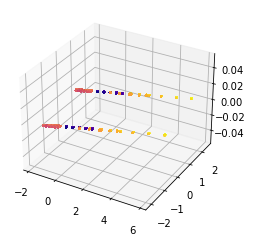

In [153]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

plt.scatter(transformed_in_4d[:,0], transformed_in_4d[:,1], transformed_in_4d[:,2], c=transformed_in_4d[:,3],
           cmap='plasma');

The straight line patterns in all of these visualizations are interesting to me. However, we're getting away from the point of this notebook - to cluster the mall customers in the dataset provided.

Keeping four or fewer components in the dataset is not explaining enough of the variance in the dataset, so I am going to perform principal components analysis with all components kept, examine the cumulative explained variance ratio at each component, and then select an appropriate one to use as a transformer before clustering.

In [155]:
pca = PCA(random_state=34)

principal_components = pca.fit_transform(transformed)

print(np.cumsum(pca.explained_variance_ratio_))

[0.13412572 0.26744549 0.378744   0.47022392 0.55891231 0.63735074
 0.71275964 0.7855565  0.85686413 0.9270582  0.9942442  1.
 1.         1.         1.        ]


Based on the cumulative explained variance ratio, we can explain virtually all of the variance in our data with the top 12 principal components (and we can do quite well with only the top 10.)

In [156]:
pca = PCA(n_components=10, random_state=34)

principal_10_components = pca.fit_transform(transformed)

scores = []
for k in range(2, 10):
    k_means = KMeans(n_clusters=k)
    k_means.fit(principal_10_components)
    scores.append(ch_score(principal_10_components, k_means.labels_))

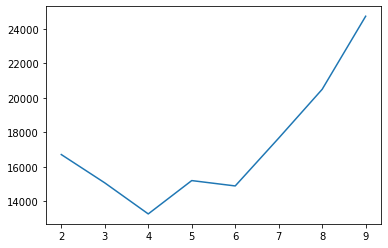

In [157]:
fig, ax = plt.subplots()

plt.plot(range(2, 10), scores);

In [159]:
k_means = KMeans(n_clusters=4)
k_means.fit(principal_10_components)

silhouette_score(principal_10_components, k_means.labels_)

0.21808711260151856

The silhouette score does not look promising. But let's try grouping the data using the top 10 principal components and 4 clusters.

In [193]:
clustered_data = pd.concat([data, pd.Series(k_means.labels_, name='cluster')], axis=1)

In [194]:
for i in range(4):
    current_cluster = clustered_data.loc[clustered_data.cluster == i]
    print(f'Current cluster: {i}')
    print(f'Size: {len(current_cluster)}, {round(len(current_cluster)/len(data)*100)}% of the data')
    print('Gender:')
    print(current_cluster.gender.value_counts(normalize=True))
    print('Age:')
    print(current_cluster.age.describe())
    print('Category:')
    print(current_cluster.category.value_counts(normalize=True))
    print('Average quantity:')
    print(current_cluster.quantity.mean())
    print('Stddev:')
    print(current_cluster.quantity.std())
    print('Average price:')
    print(current_cluster.price.mean())
    print('Average price per item:')
    print(current_cluster.avg_price_per_item.mean())

Current cluster: 0
Size: 29891, 30% of the data
Gender:
Male    1.0
Name: gender, dtype: float64
Age:
count    29891.000000
mean        43.427152
std         15.014310
min         18.000000
25%         30.000000
50%         43.000000
75%         56.000000
max         69.000000
Name: age, dtype: float64
Category:
Clothing           0.462848
Cosmetics          0.201633
Food & Beverage    0.199793
Books              0.069419
Souvenir           0.066308
Name: category, dtype: float64
Average quantity:
3.0022080224816836
Stddev:
1.4196660871298852
Average price:
450.17098323910204
Average price per item:
149.96431333846309
Current cluster: 1
Size: 10087, 10% of the data
Gender:
Female    0.603252
Male      0.396748
Name: gender, dtype: float64
Age:
count    10087.000000
mean        43.326262
std         15.081875
min         18.000000
25%         30.000000
50%         43.000000
75%         56.000000
max         69.000000
Name: age, dtype: float64
Category:
Toys    1.0
Name: category, dtype:

Though I wasn't impressed with the model's silhouette score, I am somewhat impressed with the clusters themselves.

To me, it looks like cluster 0 could be men buying gifts for women, cluster 1 is almost certainly parents buying gifts for their children, cluster 2 is women shopping for themselves, and cluster 3 is people shopping for shoes or technology. It's interesting to me that shoes and technology ended up being grouped together - they appear to be the two highest spend categories in the dataset.

The next step for this analysis is to visualize the results of the clustering.

In [178]:
clustered_data.head()

,customer_id,gender,age,category,quantity,price,payment_method,cluster
0,44140,Female,28,Clothing,5,1500.40,Credit Card,2
1,3630,Male,21,Shoes,3,1800.51,Debit Card,3
2,52143,Male,20,Clothing,1,300.08,Cash,0
3,99029,Female,66,Shoes,5,3000.85,Credit Card,3
4,27838,Female,53,Books,4,60.60,Cash,2


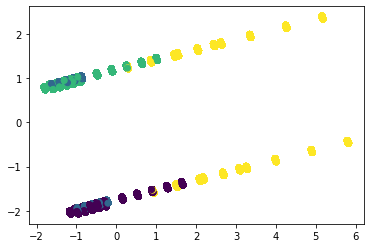

In [191]:
pca2 = PCA(n_components=2, random_state=34)
transformed_in_2d = pca2.fit_transform(transformed)

fig, ax = plt.subplots()

plt.scatter(transformed_in_2d[:, 0], transformed_in_2d[:, 1], c=k_means.labels_, cmap='viridis');

Reducing the dimensions of the original data to two principal components, we can visualize the four clusters as above.

It is interesting that the blue and the yellow are in both lines and seem to run perpendicular to the two lines formed by the data, whereas the purple and green lie along the lines.

However, as far as business applications, it will be more useful to visualize the key metrics associated with each cluster. My goal is to do this in a dashboard format.

#### Next Steps

Create a dashboard with some or all of the following components:

Top left

LINE PLOT
- Total spend for each mall month-over-month (line plot with markers, different colors; can you make the line bold and bring to the front with hover?)

Bottom left

MAP with DESCRIPTIVE STATS
- Map with locations of the 10 malls as pins
- Hover over pin (or click on pin) to see summary stats for that particular mall (e.g. total spend)
- Comparison bubbles on the right side (avg. total spend, top category, etc. across all malls)

Top right

BAR CHARTS
- Bar chart with total spend per cluster
- to the left of above / towards middle: Bar chart with percentage of customers in each cluster
- to the left of above / in the middle: Bar chart of payment methods by cluster (if there is room)

Bottom right

Linked PIE CHART and DESCRIPTIVE STATS for each category
- Category pie charts per cluster (see below for dynamicity)
- Breakout of average price per item, number of items, total spend *per category* by cluster (could be triggered by hovering over a particular category in the pie chart for a cluster)